# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import syft as sy
import copy
hook = sy.TorchHook(torch)

In [3]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
# create a couple workers
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")

secure_worker_a = sy.VirtualWorker(hook, id="secure_worker_a")
secure_worker_b = sy.VirtualWorker(hook, id="secure_worker_b")

In [6]:
import torchvision
from torch.utils.data import DataLoader, random_split

federated_train_loader = sy.FederatedDataLoader(
    torchvision.datasets.ImageFolder(root='/home/zhaojia-raoxy/data/train_yeo',
                                     transform=torchvision.transforms.ToTensor()).federate((bob, alice)),
    batch_size=200,
    shuffle=True,**kwargs)


federated_test_loader = sy.FederatedDataLoader(
    torchvision.datasets.ImageFolder(root='/home/zhaojia-raoxy/data/verify_yeo',
                                     transform=torchvision.transforms.ToTensor()).federate((secure_worker_a, secure_worker_b)),
    batch_size=200,
    shuffle=False,**kwargs)

#  CNN

模型来自https://github.com/LiYangHart/Intrusion-Detection-System-Using-CNN-and-Transfer-Learning/blob/main/2-CNN_Model_Development%26Hyperparameter%20Optimization.ipynb

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.global_avg_pooling(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # 添加 softmax 激活函数
        return x

In [8]:
model = SimpleCNN(num_classes=5).to(device)
# 在每个工作节点上创建模型的副本
# models = [model.copy().send(worker) for worker in workers]
criterion = nn.CrossEntropyLoss()
optimizers = optim.SGD(model.parameters(),lr=0.001)

In [9]:
# # 加载优化器，注意是个字典
# optimizers = {}
# for worker in federated_train_loader.workers:
#     optimizers[worker] = torch.optim.Adam(params=model.parameters(), lr=0.001)

# 训练

In [10]:
loss_test=[]
acc_test=[]

def test(model, device, federated_test_loader, batch_size): 
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
            model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            n+=target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
            model.get()
            test_loss += loss.get() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().get()

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/ n)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [11]:
loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizers, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizers.zero_grad()
        output = model(data)
        n+=target.shape[0]
        loss = criterion(output, target.long())
        loss.backward()
        
#         optimizer=optimizers[data.location.id]
        optimizers.step()
        
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
        correct += pred.eq(target.view_as(pred)).sum().get()
        train_loss+=loss.get()
        model.get() # <-- NEW: get the model back

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)
    
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
    100. * correct /n))

In [ ]:
for epoch in range(100):
    train(model, device, federated_train_loader, optimizers, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 1.6097, Accuracy: 10582/52800 (20%)
Test set: Average loss: 1.6099, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6097, Accuracy: 10631/52800 (20%)
Test set: Average loss: 1.6099, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6097, Accuracy: 10609/52800 (20%)
Test set: Average loss: 1.6098, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6096, Accuracy: 10532/52800 (20%)
Test set: Average loss: 1.6098, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6097, Accuracy: 10570/52800 (20%)
Test set: Average loss: 1.6098, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6095, Accuracy: 10597/52800 (20%)
Test set: Average loss: 1.6098, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6096, Accuracy: 10541/52800 (20%)
Test set: Average loss: 1.6098, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6094, Accuracy: 10651/52800 (20%)
Test set: Average loss: 1.6097, Accuracy: 3457/17600 (20%)
Train set: Average loss: 1.6096, Accurac

# 结果保存

In [23]:
save_name='CNN_CarHacking_fl'

In [24]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/CNN_CarHacking_fl.pt


In [25]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/CNN_CarHacking_fl.h5


/home/zhaojia-raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SimpleCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 分析

In [26]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [27]:
loss_test =np.array([tensor.item() for tensor in loss_test], dtype=np.float32)

In [28]:
loss_train=np.array([tensor.item() for tensor in loss_train], dtype=np.float32)

In [29]:
acc_train=np.array([tensor.item() for tensor in acc_train], dtype=np.float32)

In [30]:
acc_test=np.array([tensor.item() for tensor in acc_test], dtype=np.float32)

In [31]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("/home/zhaojia-raoxy/files/{}".format(save_name),index=False)

<IPython.core.display.Javascript object>


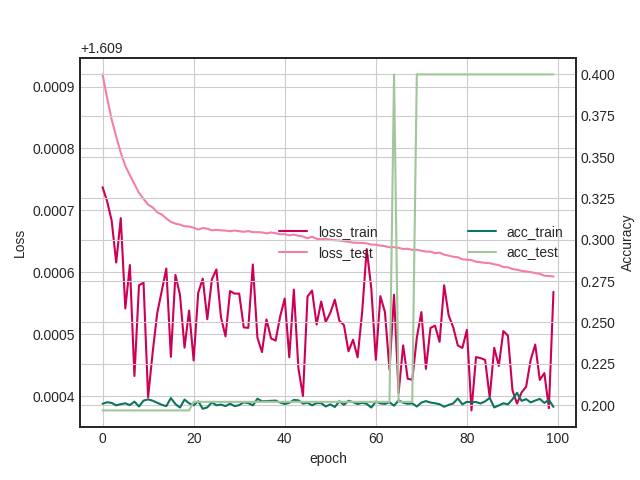

In [33]:
mpl.style.use('seaborn-white')
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()